# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [6]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/sthiruvallur/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sthiruvallur/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [14]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target
print("Y[50000]:"), Y[65000,]

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
print("Type of train_data: {0}  Type of test_data: {1}".format(type(train_data), type(test_data)))
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

Y[50000]: 4.0
data shape:  (70000, 784)
label shape: (70000,)
Type of train_data: <type 'numpy.ndarray'>  Type of test_data: <type 'numpy.ndarray'>


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

Type of first_image:<type 'numpy.ndarray'> Type of value:<type 'numpy.float64'> Value:0.0
Shape of first_image: (784,)


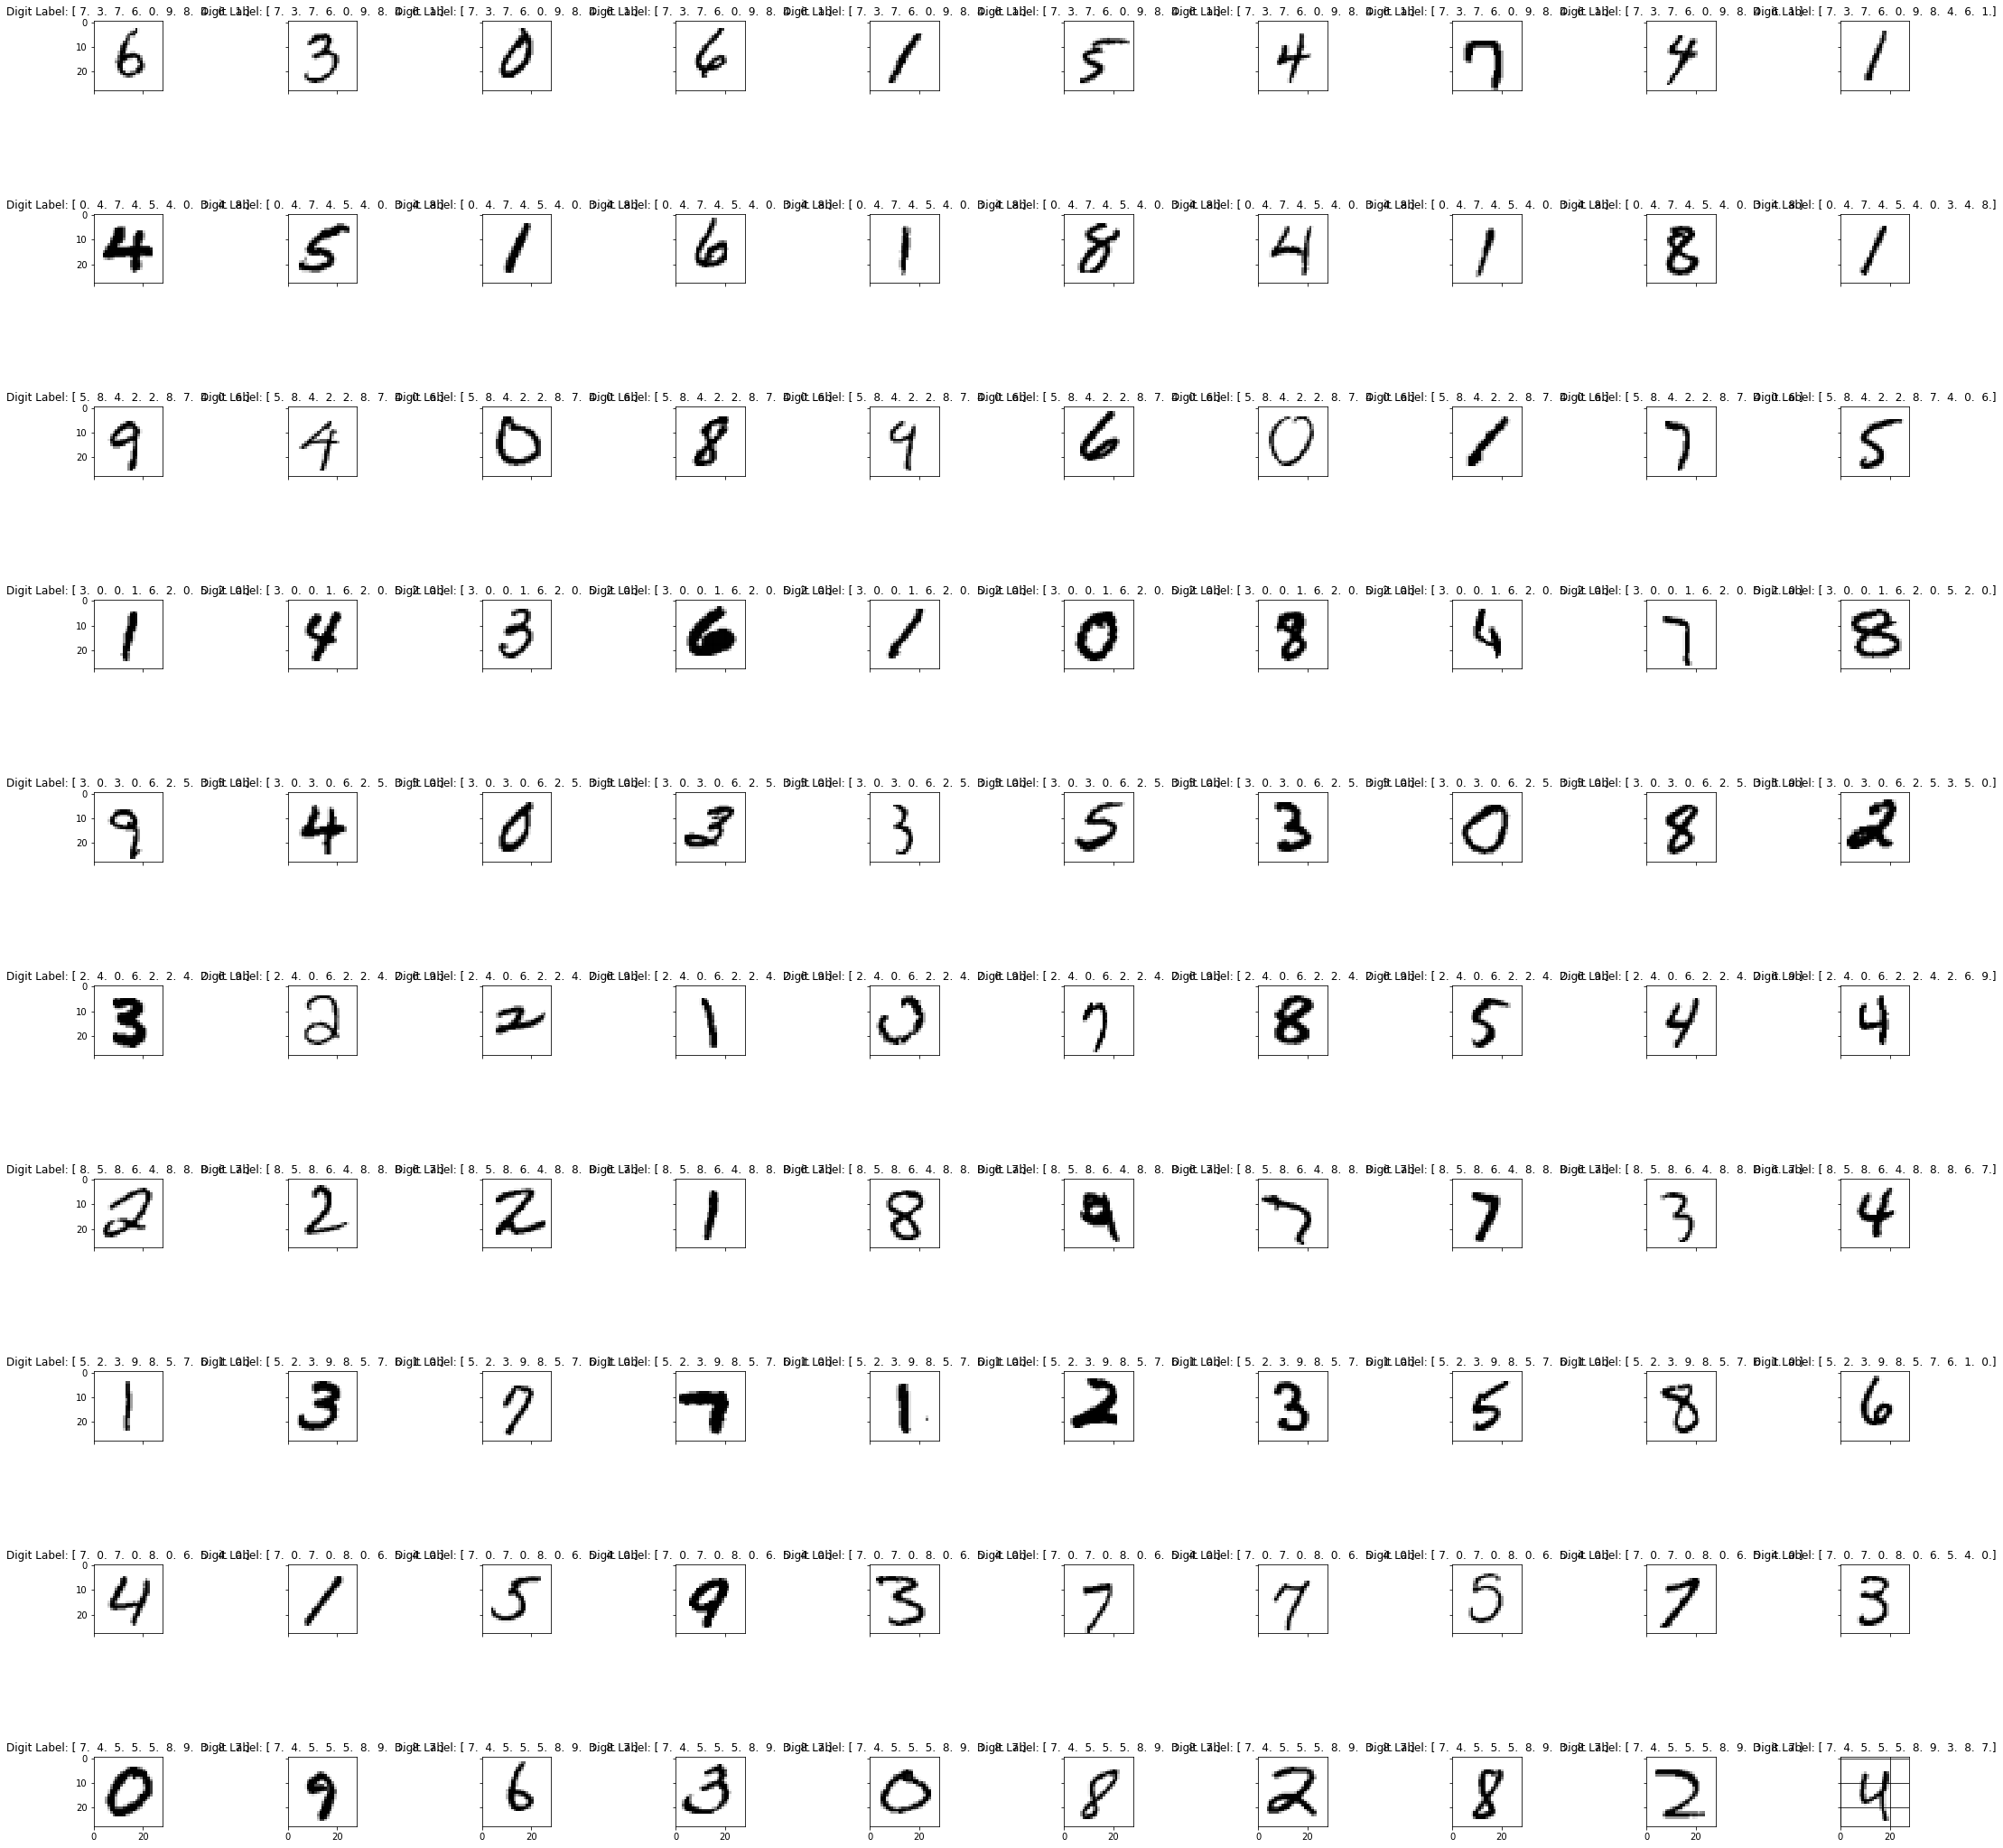

In [13]:
#def P1(num_examples=10):

### STUDENT START ###
plt.clf()
plt.style.use('seaborn-muted')

first_image = X[30000,:]
first_image_list = [np.array(a, dtype=np.float64) for a in first_image]
converted_first_image = np.array(first_image_list)
print("Type of first_image:{0} Type of value:{1} Value:{2}").format(type(converted_first_image), type(converted_first_image[400]), converted_first_image[400])
print("Shape of first_image:"), first_image.shape
first_label = Y[30000]

images_to_plot = 10*10
random_indices = np.random.randint(70000, size=(10,10))

sample_images = X[random_indices, :]
sample_labels = Y[random_indices]

# 784 columns correspond to 28x28 image
#plottable_image = np.reshape(first_image, (28, 28))

# Plot the image
#plt.imshow(plottable_image, cmap='gray_r')
#plt.title('Digit Label: {}'.format(first_label))

fig,axes = plt.subplots(10,10,
                        figsize=(30,30),
                        sharex=True,
                        sharey=True,
                        subplot_kw=dict(adjustable='box-forced', aspect='equal'))

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rc('grid',linestyle="-", color='black')

for i in range(10*10):
    # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
    subplot_row = i//10 
    subplot_col = i%10  
    ax = axes[subplot_row, subplot_col]
    
    # plot image on subplot
    plottable_image = np.reshape(X[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_title('Digit Label: {}'.format(sample_labels[subplot_row]))
    ax.set_xbound([0,28])

plt.tight_layout()
plt.grid(True)

#plt.imshow(np.reshape(train_data[0],[10,10]),cmap='Greys_r')
#plt.show()

### STUDENT END ###

#P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [16]:
#def P2(k_values):

### STUDENT START ###
# try out some different k here
k_values = [1,3,5,7,9]
for k_value in k_values:
    model = KNeighborsClassifier(n_neighbors=k_value)
    model.fit(mini_train_data, mini_train_labels)
    preds = model.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: 
            correct += 1
        total += 1
    print('neighbhors: %1d total: %3d  correct: %3d  accuracy: %3.2f' 
          %(k_value, total, correct, 1.0*correct/total)) 
    if k_value == 1:
        print(classification_report(dev_labels, preds))
        
### STUDENT END ###

#k_values = [1, 3, 5, 7, 9]
#P2(k_values)

neighbhors: 1 total: 1000  correct: 888  accuracy: 0.89
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

neighbhors: 3 total: 1000  correct: 878  accuracy: 0.88
neighbhors: 5 total: 1000  correct: 869  accuracy: 0.87
neighbhors: 7 total: 1000  correct: 865  accuracy: 0.86
neighbhors: 9 total: 1000  correct: 863  accuracy: 0.86
The most difficult digit based for K=1 is 2 based on its low recall value


ANSWER: The most difficult digit based for K=1 is 9 based on its low F-1 score

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [17]:
#def P3(train_sizes, accuracies):

### STUDENT START ###
train_size_list = [100, 200,400, 800,1600,3200,6400, 12800, 25000]
accuracy_list = []

def p3_time_test(train_sizes, accuracies):
    for train_size in train_sizes:
        temp_train_data, temp_train_labels = X[:train_size], Y[:train_size]
        model = KNeighborsClassifier(n_neighbors=1)
        start_time = time.time()
        model.fit(temp_train_data, temp_train_labels)
        preds = model.predict(dev_data)
        end_time   = time.time()
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: 
                correct += 1
            total += 1
        accuracies.append(1.0*correct/total)
        print('train_size=%3d accuracy: %3.2f time_elapsed: %3.2f seconds' 
              %(train_size, 1.0*correct/total, round(end_time-start_time,3)))

p3_time_test(train_size_list, accuracy_list)
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
#accuracies = []
#P3(train_sizes, accuracies)

train_size=100 accuracy: 0.69 time_elapsed: 0.15 seconds
train_size=200 accuracy: 0.78 time_elapsed: 0.20 seconds
train_size=400 accuracy: 0.82 time_elapsed: 0.40 seconds
train_size=800 accuracy: 0.86 time_elapsed: 0.82 seconds
train_size=1600 accuracy: 0.89 time_elapsed: 1.67 seconds
train_size=3200 accuracy: 0.91 time_elapsed: 3.41 seconds
train_size=6400 accuracy: 0.94 time_elapsed: 6.97 seconds
train_size=12800 accuracy: 0.94 time_elapsed: 14.42 seconds
train_size=25000 accuracy: 0.96 time_elapsed: 31.03 seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Prediction of n=60000 with train_sizes is [ 1.24581382]
Prediction of n=60000 with log(train_sizes) is [ 1.02726656]


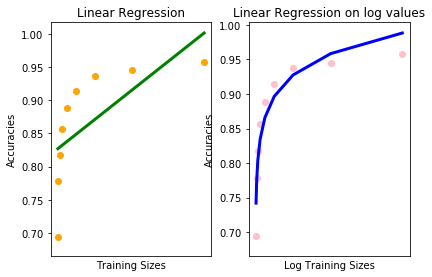

In [41]:
#def P4():

### STUDENT START ###
def apply_linear_regression(train_sizes, accuracies):
    X_sizes = np.reshape(train_sizes,(len(train_sizes),1))
    Y_sizes = accuracy_list

    lrmodel = LinearRegression()
    lrmodel.fit(X_sizes, Y_sizes)
    print("Prediction of n=60000 with train_sizes is {0}".format(lrmodel.predict(np.array(60000))))
    
    axis = plt.subplot(1,2,1)
    plt.tight_layout()
    plt.setp(axis, xticks=())
    plt.scatter(train_sizes, accuracies, color='orange')
    plt.plot(X_sizes, lrmodel.predict(X_sizes), color='green', linewidth=3)
    plt.xlabel("Training Sizes")
    plt.ylabel("Accuracies")
    plt.title('Linear Regression')

    X_log_sizes = np.log(X_sizes)
    #print(X_sizes)
    #print(X_log_sizes)
    lr_log_model = LinearRegression()
    lr_log_model.fit(X_log_sizes, Y_sizes)
    print("Prediction of n=60000 with log(train_sizes) is {0}".format(lr_log_model.predict(np.array(np.log(60000)))))
    
    axis = plt.subplot(1,2,2)
    plt.tight_layout()
    plt.setp(axis, xticks=())
    plt.scatter(train_sizes, accuracies, color='pink')
    plt.plot(X_sizes, lr_log_model.predict(X_log_sizes), color='blue', linewidth=3)
    plt.xlabel("Log Training Sizes")
    plt.ylabel("Accuracies")
    plt.title('Linear Regression on log values')
    
apply_linear_regression(train_sizes, accuracy_list)
### STUDENT END ###

#P4()

ANSWER: Linear regression predicts an accuracy of 1.246 > 1.0, which is not realistic. This is because of the values of the feature set: training size is not scaled appropriately. 
        Applying natural log on the train size helped address this a bit and resulting prediction for n=60000 is 1.027, which is much more reasonable

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [9]:
#def P5():

### STUDENT START ###

    
### STUDENT END ###

#P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [10]:
#def P6():
    
### STUDENT START ###


### STUDENT END ###

#P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
#def P7():

### STUDENT START ###


    
### STUDENT END ###

#P7()

ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [12]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

#alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#nb = P8(alphas)

In [14]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [15]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#gnb = P9()

ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [16]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()